In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pydicom as pdc
import os
import PIL
%matplotlib inline

In [3]:
import gdcm

In [9]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_sub = pd.read_csv('sample_submission.csv')

In [10]:
train.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker


In [11]:
print(train.head())
print(test.head())
print(sample_sub.head())

                     Patient  Weeks   FVC    Percent  Age   Sex SmokingStatus
0  ID00007637202177411956430     -4  2315  58.253649   79  Male     Ex-smoker
1  ID00007637202177411956430      5  2214  55.712129   79  Male     Ex-smoker
2  ID00007637202177411956430      7  2061  51.862104   79  Male     Ex-smoker
3  ID00007637202177411956430      9  2144  53.950679   79  Male     Ex-smoker
4  ID00007637202177411956430     11  2069  52.063412   79  Male     Ex-smoker
                     Patient  Weeks   FVC    Percent  Age   Sex SmokingStatus
0  ID00419637202311204720264      6  3020  70.186855   73  Male     Ex-smoker
1  ID00421637202311550012437     15  2739  82.045291   68  Male     Ex-smoker
2  ID00422637202311677017371      6  1930  76.672493   73  Male     Ex-smoker
3  ID00423637202312137826377     17  3294  79.258903   72  Male     Ex-smoker
4  ID00426637202313170790466      0  2925  71.824968   73  Male  Never smoked
                    Patient_Week   FVC  Confidence
0  ID00419637

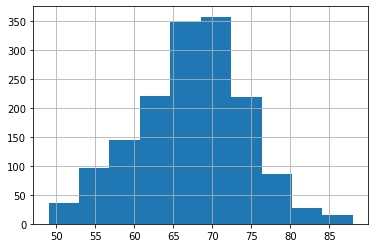

In [12]:
train['Age'].hist();

In [13]:
train_id = os.listdir('train')
test_id = os.listdir('test')

In [14]:
len(train_id), len(test_id)

(176, 5)

In [15]:
train['Patient'].unique().shape, test['Patient'].unique().shape

((176,), (5,))

In [17]:
def sort_snaps(snaps_for_patient):
    numbers = []
    for name in snaps_for_patient:
        number, _ = name.split('.')
        numbers.append(int(number))

    sorted_snaps = []
    for num in sorted(numbers):
        new_name = str(num) + '.dcm'
        sorted_snaps.append(new_name)

    return sorted_snaps

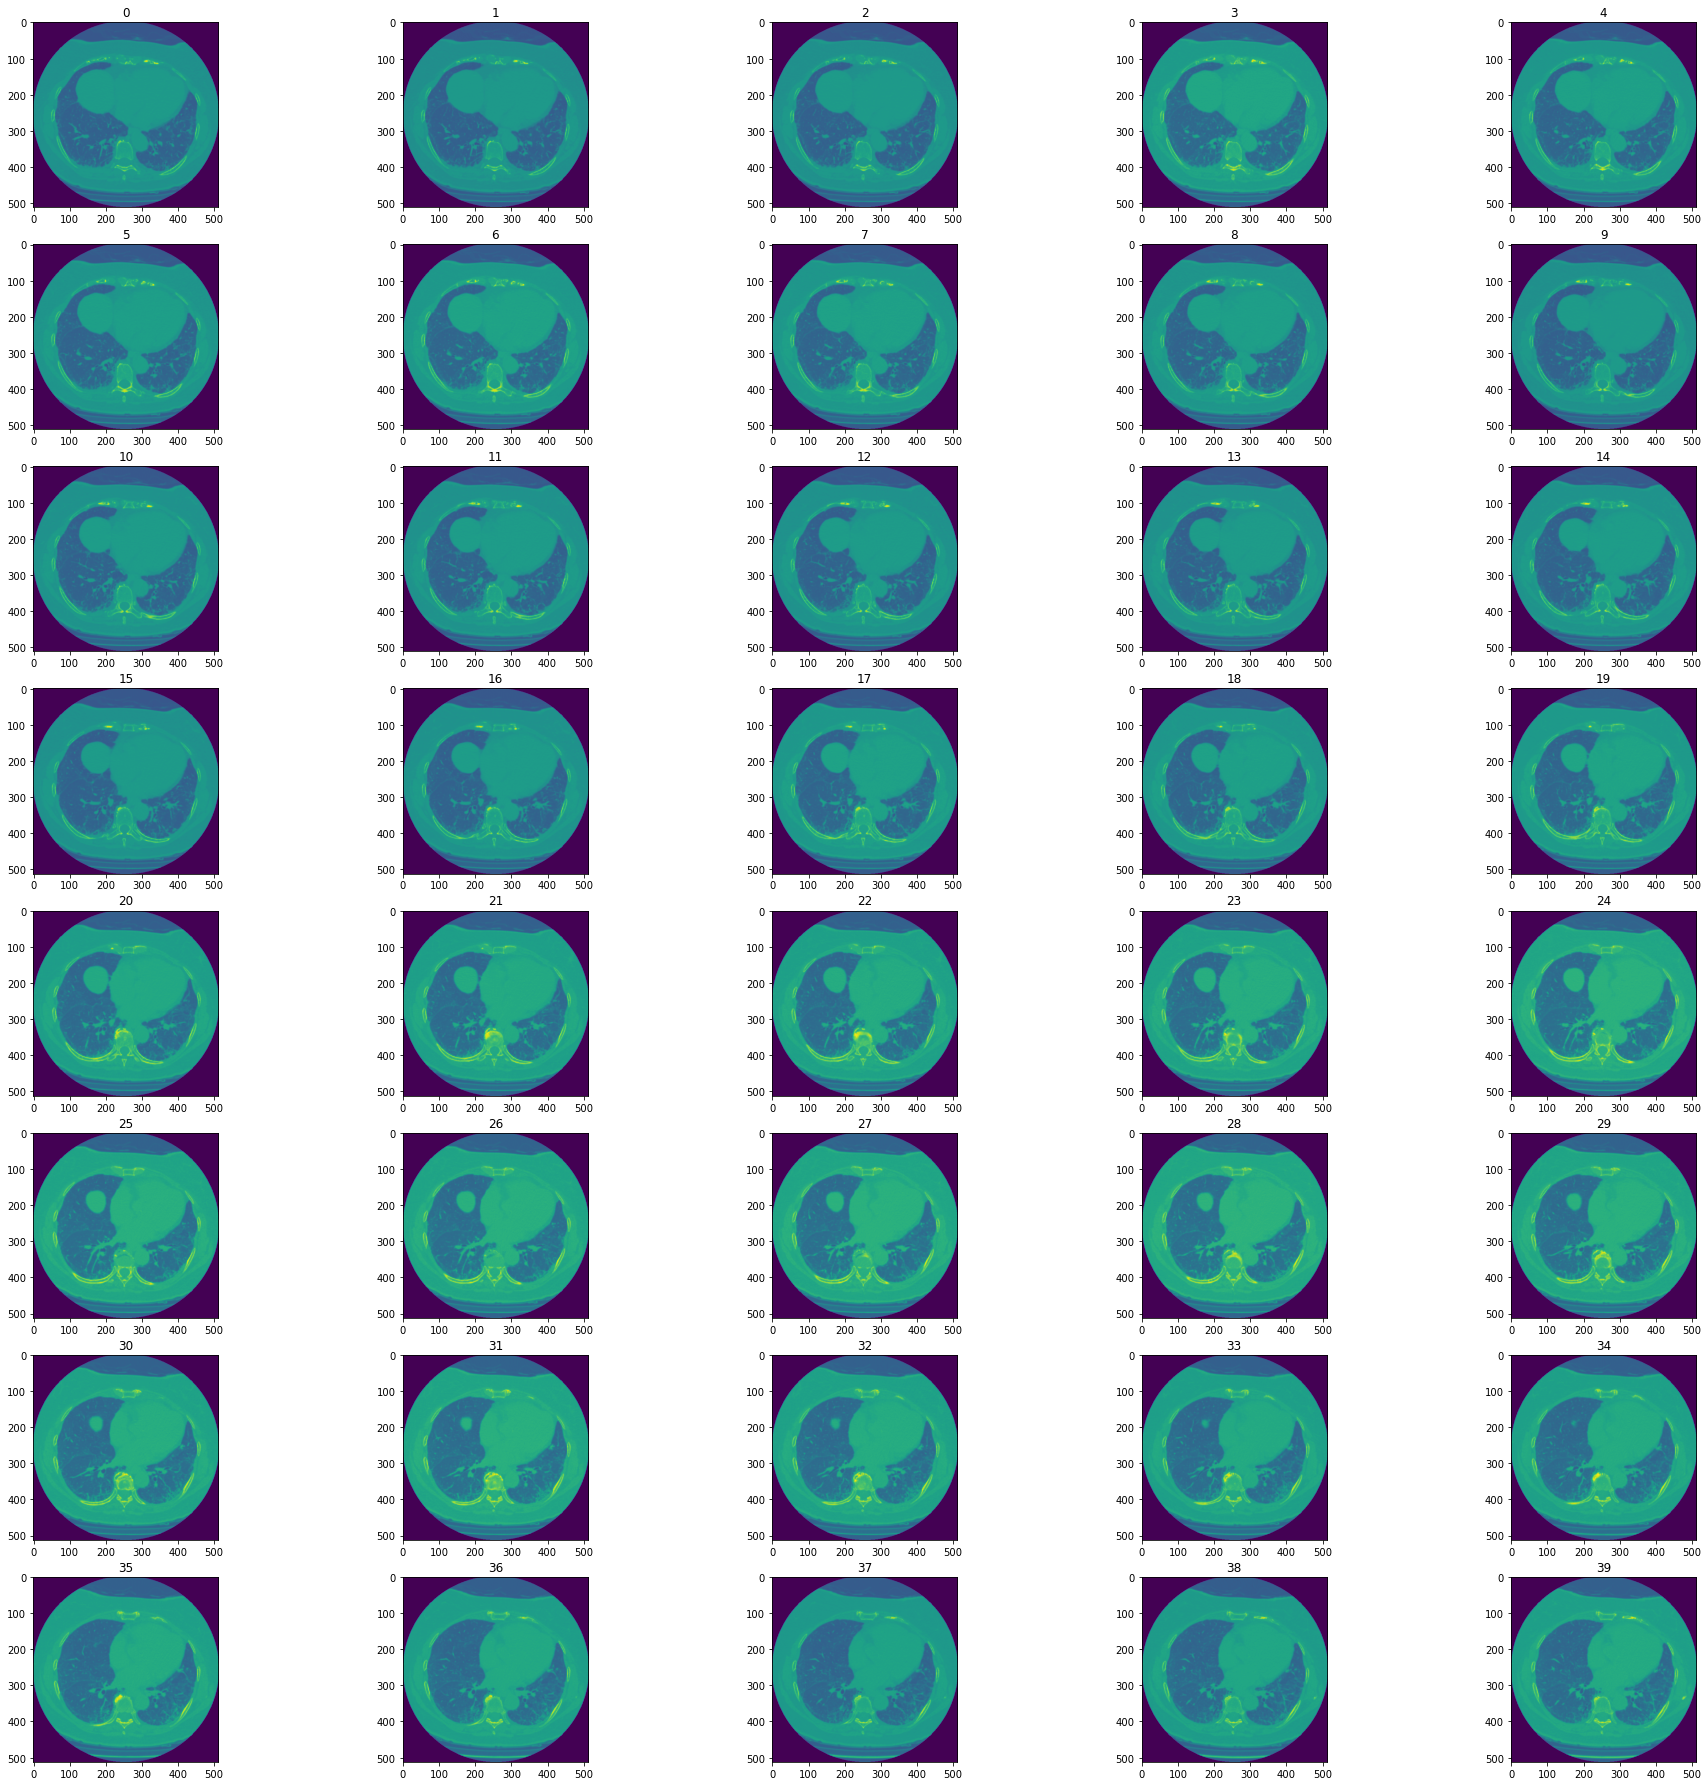

In [18]:
fig = plt.figure(figsize=(32, 32))
num = 8
snaps_for_patient = os.listdir(os.path.join('train', train_id[num]))

for i, snap in enumerate(sort_snaps(snaps_for_patient)[200:240]):
    path = os.path.join('train', train_id[num], snap)
    file = pdc.read_file(path)
    picture = file.pixel_array
    ax = fig.add_subplot(8, 5, i+1)
    ax.title.set_text(i)
    ax.imshow(picture)

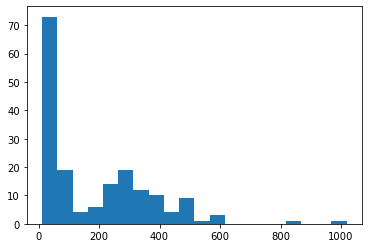

In [19]:
lens = []
for patient_id in train_id:
    snaps_for_patient = os.listdir(os.path.join('train', patient_id))
    lens.append(len(snaps_for_patient))
plt.hist(np.array(lens), bins=20);

# Generating samples of snaps and count shapes

In [92]:
def generate_snaps(snaps_for_patient, num_samples=5):
    numbers = np.empty_like(snaps_for_patient, dtype=np.int)
    for i, name in enumerate(snaps_for_patient):
        number, _ = name.split('.')
        numbers[i] = int(number)
    low = int(len(numbers)*0.2)
    high = int(len(numbers)*0.8)
    numbers = sorted(numbers)
    numbers = numbers[low:high]
    np.random.shuffle(numbers)
    generated_list = list(map(lambda x: str(x) + '.dcm', numbers[:num_samples]))
    return generated_list

In [93]:
shapes = {}
for patient_id in train_id:
    snaps_for_patient = os.listdir(os.path.join('train', patient_id))
    for i, snap in enumerate(sort_snaps(generate_snaps(snaps_for_patient))):
        path = os.path.join('train', patient_id, snap)
        file = pdc.read_file(path)
        picture = file.pixel_array
        size = picture.shape
        if size not in shapes:
            shapes[size] = 1
        else:
            shapes[size] += 1

In [94]:
shapes

{(512, 512): 660,
 (768, 768): 170,
 (843, 888): 5,
 (733, 888): 5,
 (788, 888): 5,
 (752, 888): 10,
 (1302, 1302): 5,
 (734, 888): 5,
 (632, 632): 10,
 (1100, 888): 5}

# Generating tensors (5, 224, 224)

In [115]:
import torch
import torchvision
from torchvision import transforms

In [116]:
patient_pic = {}
for patient_id in train_id:
    print(patient_id)
    snaps_for_patient = os.listdir(os.path.join('train', patient_id))
    for i, snap in enumerate(sort_snaps(generate_snaps(snaps_for_patient))):
        path = os.path.join('train', patient_id, snap)
        file = pdc.read_file(path)
        picture = file.pixel_array
        print(transforms.ToTensor(picture))

ID00007637202177411956430


TypeError: ToTensor() takes no arguments

In [126]:
new_train = pd.get_dummies(new_train)

In [136]:
new_train.Num_pics = 2

In [137]:
new_train

,Weeks,FVC,Percent,Age,Num_pics,Patient_ID00007637202177411956430,Patient_ID00009637202177434476278,Patient_ID00010637202177584971671,Patient_ID00011637202177653955184,Patient_ID00012637202177665765362,...,Sex_Male,SmokingStatus_Currently smokes,SmokingStatus_Ex-smoker,SmokingStatus_Never smoked,Sex_SmokingStatus_Female_Currently smokes,Sex_SmokingStatus_Female_Ex-smoker,Sex_SmokingStatus_Female_Never smoked,Sex_SmokingStatus_Male_Currently smokes,Sex_SmokingStatus_Male_Ex-smoker,Sex_SmokingStatus_Male_Never smoked
0,-4,2315,58.253649,79,2,1,0,0,0,0,...,1,0,1,0,0,0,0,0,1,0
1,5,2214,55.712129,79,2,1,0,0,0,0,...,1,0,1,0,0,0,0,0,1,0
2,7,2061,51.862104,79,2,1,0,0,0,0,...,1,0,1,0,0,0,0,0,1,0
3,9,2144,53.950679,79,2,1,0,0,0,0,...,1,0,1,0,0,0,0,0,1,0
4,11,2069,52.063412,79,2,1,0,0,0,0,...,1,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1544,13,2712,66.594637,73,2,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,1
1545,19,2978,73.126412,73,2,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,1
1546,31,2908,71.407524,73,2,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,1
1547,43,2975,73.052745,73,2,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,1
